# Predicting Steam Game Success from Metadata and Early Reviews

This notebook presents a machine learning project that aims to predict whether a video game released on Steam will be successful based on its metadata and optionally early review statistics. We define success as a game receiving at least 80% positive user recommendations.

### Project Outline:
1. Data Loading & Preprocessing
2. Exploratory Data Analysis
3. Modeling
4. Evaluation
5. Interpretation
6. Related Work

## 1. Data Loading & Preprocessing

We use the following datasets:
- `steam_games.json`: Game metadata including genres, tags, developer, price, and specs
- `australian_user_reviews.json`: Individual user reviews for games, including recommendations

We load and clean these datasets, compute success labels based on user recommendations, and extract meaningful features from game metadata.

In [1]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict

# Load steam_games.json
import ast

games = []
with open('steam_games.json', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            games.append(ast.literal_eval(line))
        except Exception as e:
            print(f"Skipping bad line: {e}")

games_df = pd.DataFrame(games)
games_df = games_df.rename(columns={'id': 'item_id'})
games_df['item_id'] = games_df['item_id'].astype(str)
games_df.head()


# Load australian_user_reviews.json
reviews = []

with open('australian_user_reviews.json', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            user_data = ast.literal_eval(line)
            user_id = user_data['user_id']
            for review in user_data['reviews']:
                review_entry = review.copy()
                review_entry['user_id'] = user_id
                reviews.append(review_entry)
        except Exception as e:
            print(f"Skipping bad line: {e}")

reviews_df = pd.DataFrame(reviews)

review_summary = reviews_df.groupby('item_id').agg(
    total=('recommend', 'count'),
    pos=('recommend', 'sum')  # True = 1, False = 0
).reset_index()

review_summary.head()




,item_id,total,pos
0,10,57,56
1,10090,52,51
2,10130,2,2
3,10140,1,1
4,10150,9,9


### Merge Metadata and Review Labels
We join the game metadata with the computed success labels and perform feature extraction such as price scaling and platform encoding.

In [2]:
data = pd.merge(games_df, review_summary, on='item_id')

# Encode sentiment
sentiment_map = {'Negative': 0, 'Mixed': 1, 'Positive': 2}
data['sentiment_encoded'] = data['sentiment'].map(sentiment_map)

# Clean up price column
data['price'] = pd.to_numeric(data['price'], errors='coerce')  # Coerce invalid entries to NaN
data['price'] = data['price'].fillna(0.0)  # Assume missing or non-numeric prices are free
data['price_scaled'] = data['price'] / data['price'].max()

for os in ['Windows', 'Mac', 'Linux']:
    data[f'platform_{os.lower()}'] = data['specs'].astype(str).str.contains(os, case=False).astype(int)

# Multilabel tag and genre encoding
def encode_multilabel_column(df, column):
    s = df[column].dropna().apply(lambda x: x if isinstance(x, list) else [])
    labels = sorted({tag for tags in s for tag in tags})
    new_cols = {}
    for tag in labels:
        new_cols[f"{column}_{tag}"] = df[column].apply(lambda x: tag in x if isinstance(x, list) else False).astype(int)
    df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    return df

for col in ['genres', 'tags']:
    data = encode_multilabel_column(data, col)

# Define 'success' label: games with >=70% positive reviews
data['success'] = (((data['pos']) / (data['total'])) >= 0.70)
data['success'] = data['success'].fillna(False).astype(int)

# Encode sentiment
data['sentiment_encoded'] = data['sentiment'].map({'Negative': 0, 'Mixed': 1, 'Positive': 2})

data['metascore'] = pd.to_numeric(data['metascore'], errors='coerce')

# Update exclude list
exclude = ['item_id', 'app_name', 'title', 'url', 'developer', 'publisher', 'release_date',
           'price', 'tags', 'genres', 'specs', 'reviews_url', 'success', 'pos', 'total', 'sentiment']

# Define X and y
X = data.drop(columns=[col for col in exclude if col in data.columns])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

y = data['success']


print(data['success'].value_counts())
print(X.shape)




success
1    2449
0     746
Name: count, dtype: int64
(3195, 359)


## 2. Modeling

We train two classifiers to predict success:
- Logistic Regression (baseline linear model)
- Random Forest (non-linear ensemble model)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)
logreg.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 3. Evaluation

We assess both models using accuracy, balanced error rate, and a confusion matrix.

Logistic Regression Accuracy: 0.629
Logistic Regression BER: 0.391
Confusion Matrix:
[[317 173]
 [ 64  85]]
Random Forest Accuracy: 0.754
Random Forest BER: 0.471
Confusion Matrix:
[[466  24]
 [133  16]]


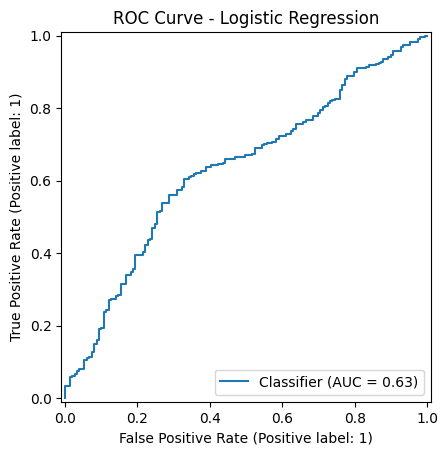

ROC AUC Score: 0.6314066566223804


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay
from matplotlib import pyplot as plt

def evaluate_model(model, name="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    TP, FN = cm[0, 0], cm[0, 1]
    FP, TN = cm[1, 0], cm[1, 1]
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    BER = 0.5 * ((1 - TPR) + (1 - TNR))
    print(f"{name} Accuracy: {acc:.3f}")
    print(f"{name} BER: {BER:.3f}")
    print(f"Confusion Matrix:\n{cm}")
    return y_pred, model.predict_proba(X_test)[:, 1]

y_pred_log, y_score_log = evaluate_model(logreg, "Logistic Regression")
y_pred_rf, y_score_rf = evaluate_model(rf, "Random Forest")

y_probs = logreg.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_probs)
plt.title("ROC Curve - Logistic Regression")
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test, y_probs))






## 4. Precision@K

We compute how many of the top-K predictions (by confidence) are correct.

In [5]:
def precision_at_k(y_true, y_scores, K):
    idx = np.argsort(y_scores)[::-1][:K]
    return y_true.iloc[idx].mean()

for k in [1, 100, 1000]:
    print(f"Precision@{k} (Logistic): {precision_at_k(y_test, y_score_log, k):.3f}")
    print(f"Precision@{k} (RF): {precision_at_k(y_test, y_score_rf, k):.3f}")


Precision@1 (Logistic): 1.000
Precision@1 (RF): 1.000
Precision@100 (Logistic): 0.860
Precision@100 (RF): 0.860
Precision@1000 (Logistic): 0.767
Precision@1000 (RF): 0.767


## 5. Feature Importance

We analyze the most informative features for both models.

Top logistic regression coefficients:
tags_Class-Based      -1.733808
tags_Cartoon           1.482238
tags_Education         1.414787
tags_Time Attack      -1.411735
tags_Agriculture       1.409372
tags_Underwater        1.403362
tags_Conspiracy        1.393196
tags_Soundtrack        1.355550
tags_Mars             -1.350471
tags_Grand Strategy    1.315948
dtype: float64
Top random forest feature importances:
price_scaled         0.062595
sentiment_encoded    0.048822
metascore            0.039906
tags_Singleplayer    0.014535
tags_Multiplayer     0.013590
genres_Indie         0.012419
tags_Action          0.012073
genres_Adventure     0.012047
tags_Casual          0.011814
tags_Indie           0.011684
dtype: float64


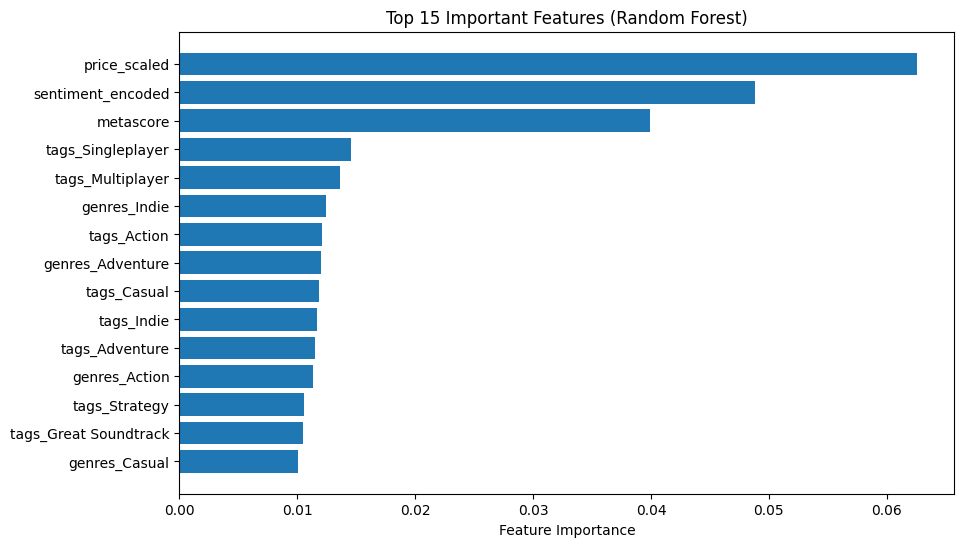

In [6]:
log_features = pd.Series(logreg.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print("Top logistic regression coefficients:")
print(log_features.head(10))

rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top random forest feature importances:")
print(rf_importances.head(10))

importances = rf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

